In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics

# data

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


#### LED OFF #####
df_led_off = df[df['LED_trial'] == 0]


### LED ON ###
df_led_on = df[df['LED_trial'] == 1]
df_led_on = df_led_on[df_led_on['LED_powerL'] == df_led_on['LED_powerR']]  # Bilateral, Left and right same power = 100

In [3]:
df_led_on_valid_trials = df_led_on[df_led_on['success'].isin([1,-1])]
print(f'len of led on valid trials = {len(df_led_on_valid_trials)}')

len of led on valid trials = 8191


# sim instead of data

In [4]:
# ############### TODO TEMP ######################3


# V_A = 1.6
# theta_A = 2.53
# V_A_post_LED = V_A + 1.8
# t_A_aff = -0.187
# t_E_aff = 0.075
# Z_E = 0
# K_max = 10

# rate_lambda = 0.118
# T_0 = 1/2220
# theta_E = 45
# T0_factor = 1

# # Increase T0 -> dec  mu and sigma, add noise
# N_sim = int(50e3)
# N_print = int(N_sim/5)
# is_LED_trial = True
# new_V_A = V_A_post_LED
# new_noise = 20
# dt = 1e-4
# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff,\
#                                                                                     t_stim_and_led_tuple[iter_num], new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, dt) for iter_num in range(N_sim))


# sim_results_df = pd.DataFrame(sim_results)
# sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice']).apply(lambda x: 1 if x > 0 else 0)
# sim_results_df_valid = sim_results_df[sim_results_df['rt'] > sim_results_df['t_stim']]

# df_led_on_valid_trials = sim_results_df_valid.copy()


# loglike fn

In [5]:
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A + 1.8
t_A_aff = -0.187
t_E_aff = 0.075
Z_E = 0
K_max = 10

In [6]:
def compute_loglike_trial(row, rate_lambda, T_0, theta_E, noise):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    # TEMP: simulated data check
    # rt = row['rt']
    # t_stim = row['t_stim']
    # t_LED = row['t_led']

    ABL = row['ABL']
    ILD = row['ILD']

    response_poke = row['response_poke']
    # TEMP: simulated data check
    # response_poke = 3 if row['choice'] == 1 else 2

    t_pts = np.arange(0, t_stim, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    CDF_PA_till_stim = trapz(P_A_LED_change, t_pts)
    trunc_factor = 1 - CDF_PA_till_stim

    if response_poke == 3:
        # up
        likelihood = up_RTs_fit_OPTIM_V_A_change_added_noise_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                         ABL, ILD, rate_lambda, T_0, noise,\
                                                              theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)
    elif response_poke == 2:
        # down
        likelihood = down_RTs_fit_OPTIM_V_A_change_added_noise_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                         ABL, ILD, rate_lambda, T_0, noise,\
                                                              theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)

    
    likelihood /= (trunc_factor + 1e-10)
    if likelihood <= 0:
        likelihood = 1e-50


    return np.log(likelihood)


def vbmc_loglike_fn(params):
    rate_lambda, T_0, theta_E, noise = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, rate_lambda, T_0, theta_E, noise) \
                                     for _, row in df_led_on_valid_trials.iterrows())
    
    return np.sum(all_loglike)

# bounds

In [7]:
rate_lambda_bounds = [0.01, 0.2]
rate_lambda_plausible_bounds =  [0.05, 0.15]

theta_E_bounds = [20, 80]
theta_E_plausible_bounds = [40, 50]

T_0_bounds = [0.1 * (1e-3), 1 * (1e-3)]
T_0_plausible_bounds = [0.2 * (1e-3), 0.6 * (1e-3)]

noise_bounds = [0, 100]
noise_plausible_bounds = [20, 80]

# priors

In [8]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    rate_lambda, T_0, theta_E, noise = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    noise_logpdf = trapezoidal_logpdf(noise, noise_bounds[0], noise_plausible_bounds[0], noise_plausible_bounds[1], noise_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + noise_logpdf

# prior + loglike

In [9]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [10]:
lb = np.array([rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], noise_bounds[0]])
ub = np.array([rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], noise_bounds[1]])

plb = np.array([rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], noise_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], noise_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
noise_0 = np.random.uniform(noise_plausible_bounds[0], noise_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, noise_0])


vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        1567.60      1168.93          inf        2        inf     start warm-up
     1         15        1282.36       195.71       144.93        2        inf     
     2         20        1407.19       571.29       747.26        2   1.48e+04     
     3         25        1230.22       210.83       147.26        2   3.75e+03     
     4         30        1232.77       217.37       129.17        2   2.89e+03     
     5         35        1386.44       501.95       396.42        2   8.79e+03     
     6         40        1229.18       344.60       399.47        2   8.33e+03     
     7         45        1251.80       396.8

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    11         65        1475.01       422.14      7011.33        2   1.18e+05     
    12         70        1237.47        57.54       275.10        2   5.57e+03     
    13         75        1427.47      1079.16       817.43        2   1.79e+04     
    14         80        1219.51        14.06      1005.37        2   1.75e+04     
    15         85        1203.94         0.29       203.52        2   3.44e+03     
    16         90        1204.47         0.23         0.52        2       11.2     
    17         95        1359.19       113.67      1954.58        2   3.35e+04     
    18        100        1243.29       136.53      4781.83        2   8.05e+04     
    19        105        1205.23        28.57       776.59        2   1.32e+04     trim data
    20        110        1205.97         3.35       168.67        2   2.82e+03     
    21        115        1206.31         0.19         9.57        2        161     
    22        120        1207.04         0.23         1.81        2

In [11]:
vbmc.save('added_noise_vbmc.pkl', overwrite=True)

In [10]:
import pickle 
with open('added_noise_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)


vp = vp.vp

# corner and diagnostics

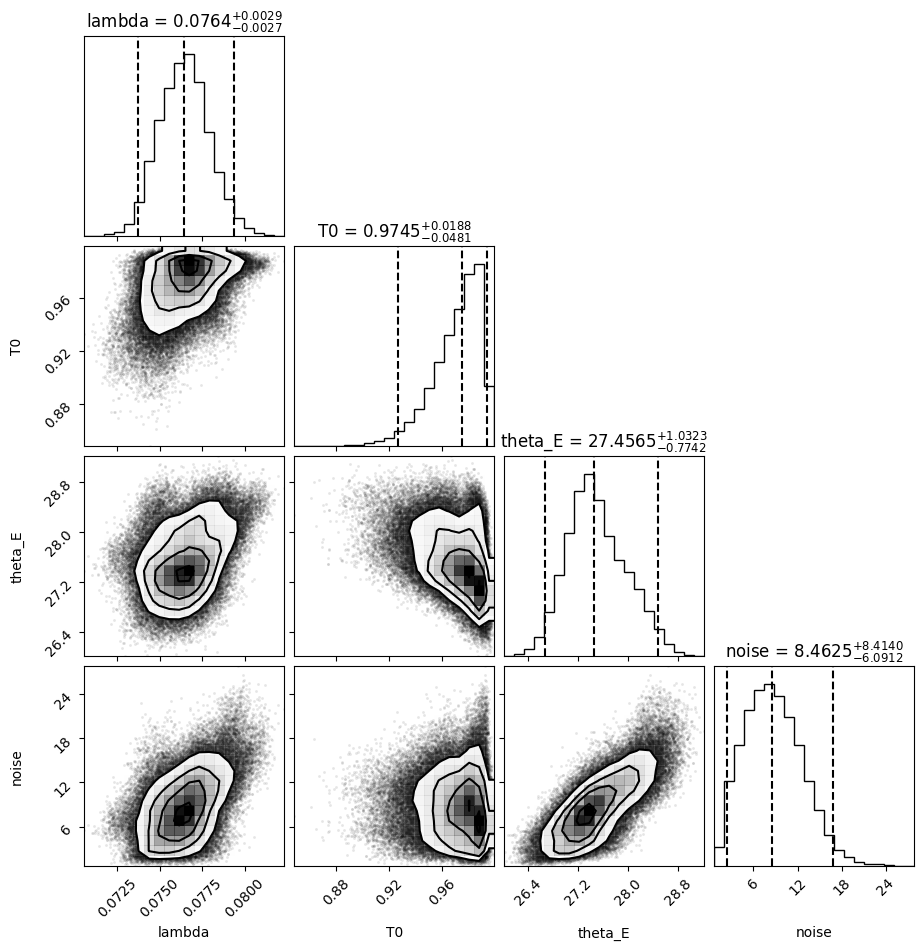

In [18]:
vp_samples = vp.sample(int(1e5))[0]

vp_samples[:, 1] *= 1e3

param_labels = ['lambda', 'T0', 'theta_E', 'noise']
# true_arr = [rate_lambda, T_0*1e3, theta_E, new_noise]
percentiles = np.percentile(vp_samples, [0, 100], axis=0)


_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    # truths=true_arr,
    title_fmt=".4f"
);

vp_samples[:, 1] *= 1e-3

# design diagnostics

In [12]:
# sim
rate_lambda_mean = np.mean(vp_samples[:, 0])
T_0_mean = np.mean(vp_samples[:, 1])
theta_E_mean = np.mean(vp_samples[:, 2])
noise_mean = np.mean(vp_samples[:, 3])

N_sim = int(1e6)
N_print = int(N_sim/5)
is_LED_trial = True
dt = 1e-4

sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                                        rate_lambda_mean, T_0_mean, theta_E_mean, Z_E, \
                                                                                            t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple_samples[iter_num], \
                                                                        V_A_post_LED, noise_mean, 1, iter_num, N_print, is_LED_trial, dt) \
                                                                              for iter_num in tqdm(range(N_sim)))


  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1919003, In iter_num: 0, ABL: 40, ILD: 16.0, t_stim: 0.336019746023377
os id: 1919006, In iter_num: 200000, ABL: 60, ILD: 8.0, t_stim: 0.44857463336219
os id: 1919049, In iter_num: 400000, ABL: 20, ILD: 16.0, t_stim: 0.268058631731852
os id: 1919057, In iter_num: 600000, ABL: 20, ILD: 16.0, t_stim: 0.238321299048446
os id: 1919007, In iter_num: 800000, ABL: 20, ILD: -4.0, t_stim: 0.257710341387882


In [13]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = sim_results_df.apply(
    lambda row: 1 if row['ILD'] * row['choice'] > 0 else 0,
    axis=1
)


# remove aborts < 0.3
sim_results_df_with_aborts = sim_results_df[ ~( (sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3) ) ]
sim_results_df_valid = sim_results_df_with_aborts[sim_results_df_with_aborts['rt'] > sim_results_df_with_aborts['t_stim']]

In [14]:
data_df_led_on_with_aborts = df_led_on[ ~( (df_led_on['abort_event'] == 3) & (df_led_on['timed_fix'] < 0.3) ) ]
data_df_led_on_with_aborts = data_df_led_on_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

data_df_led_on_valid = data_df_led_on_with_aborts[ data_df_led_on_with_aborts['success'].isin([1,-1]) ]

In [15]:
sim_diag_with_aborts = Diagnostics(sim_results_df_with_aborts)
sim_diag_valid = Diagnostics(sim_results_df_valid)

data_diag_with_aborts = Diagnostics(data_df_led_on_with_aborts)
data_diag_valid = Diagnostics(data_df_led_on_valid)

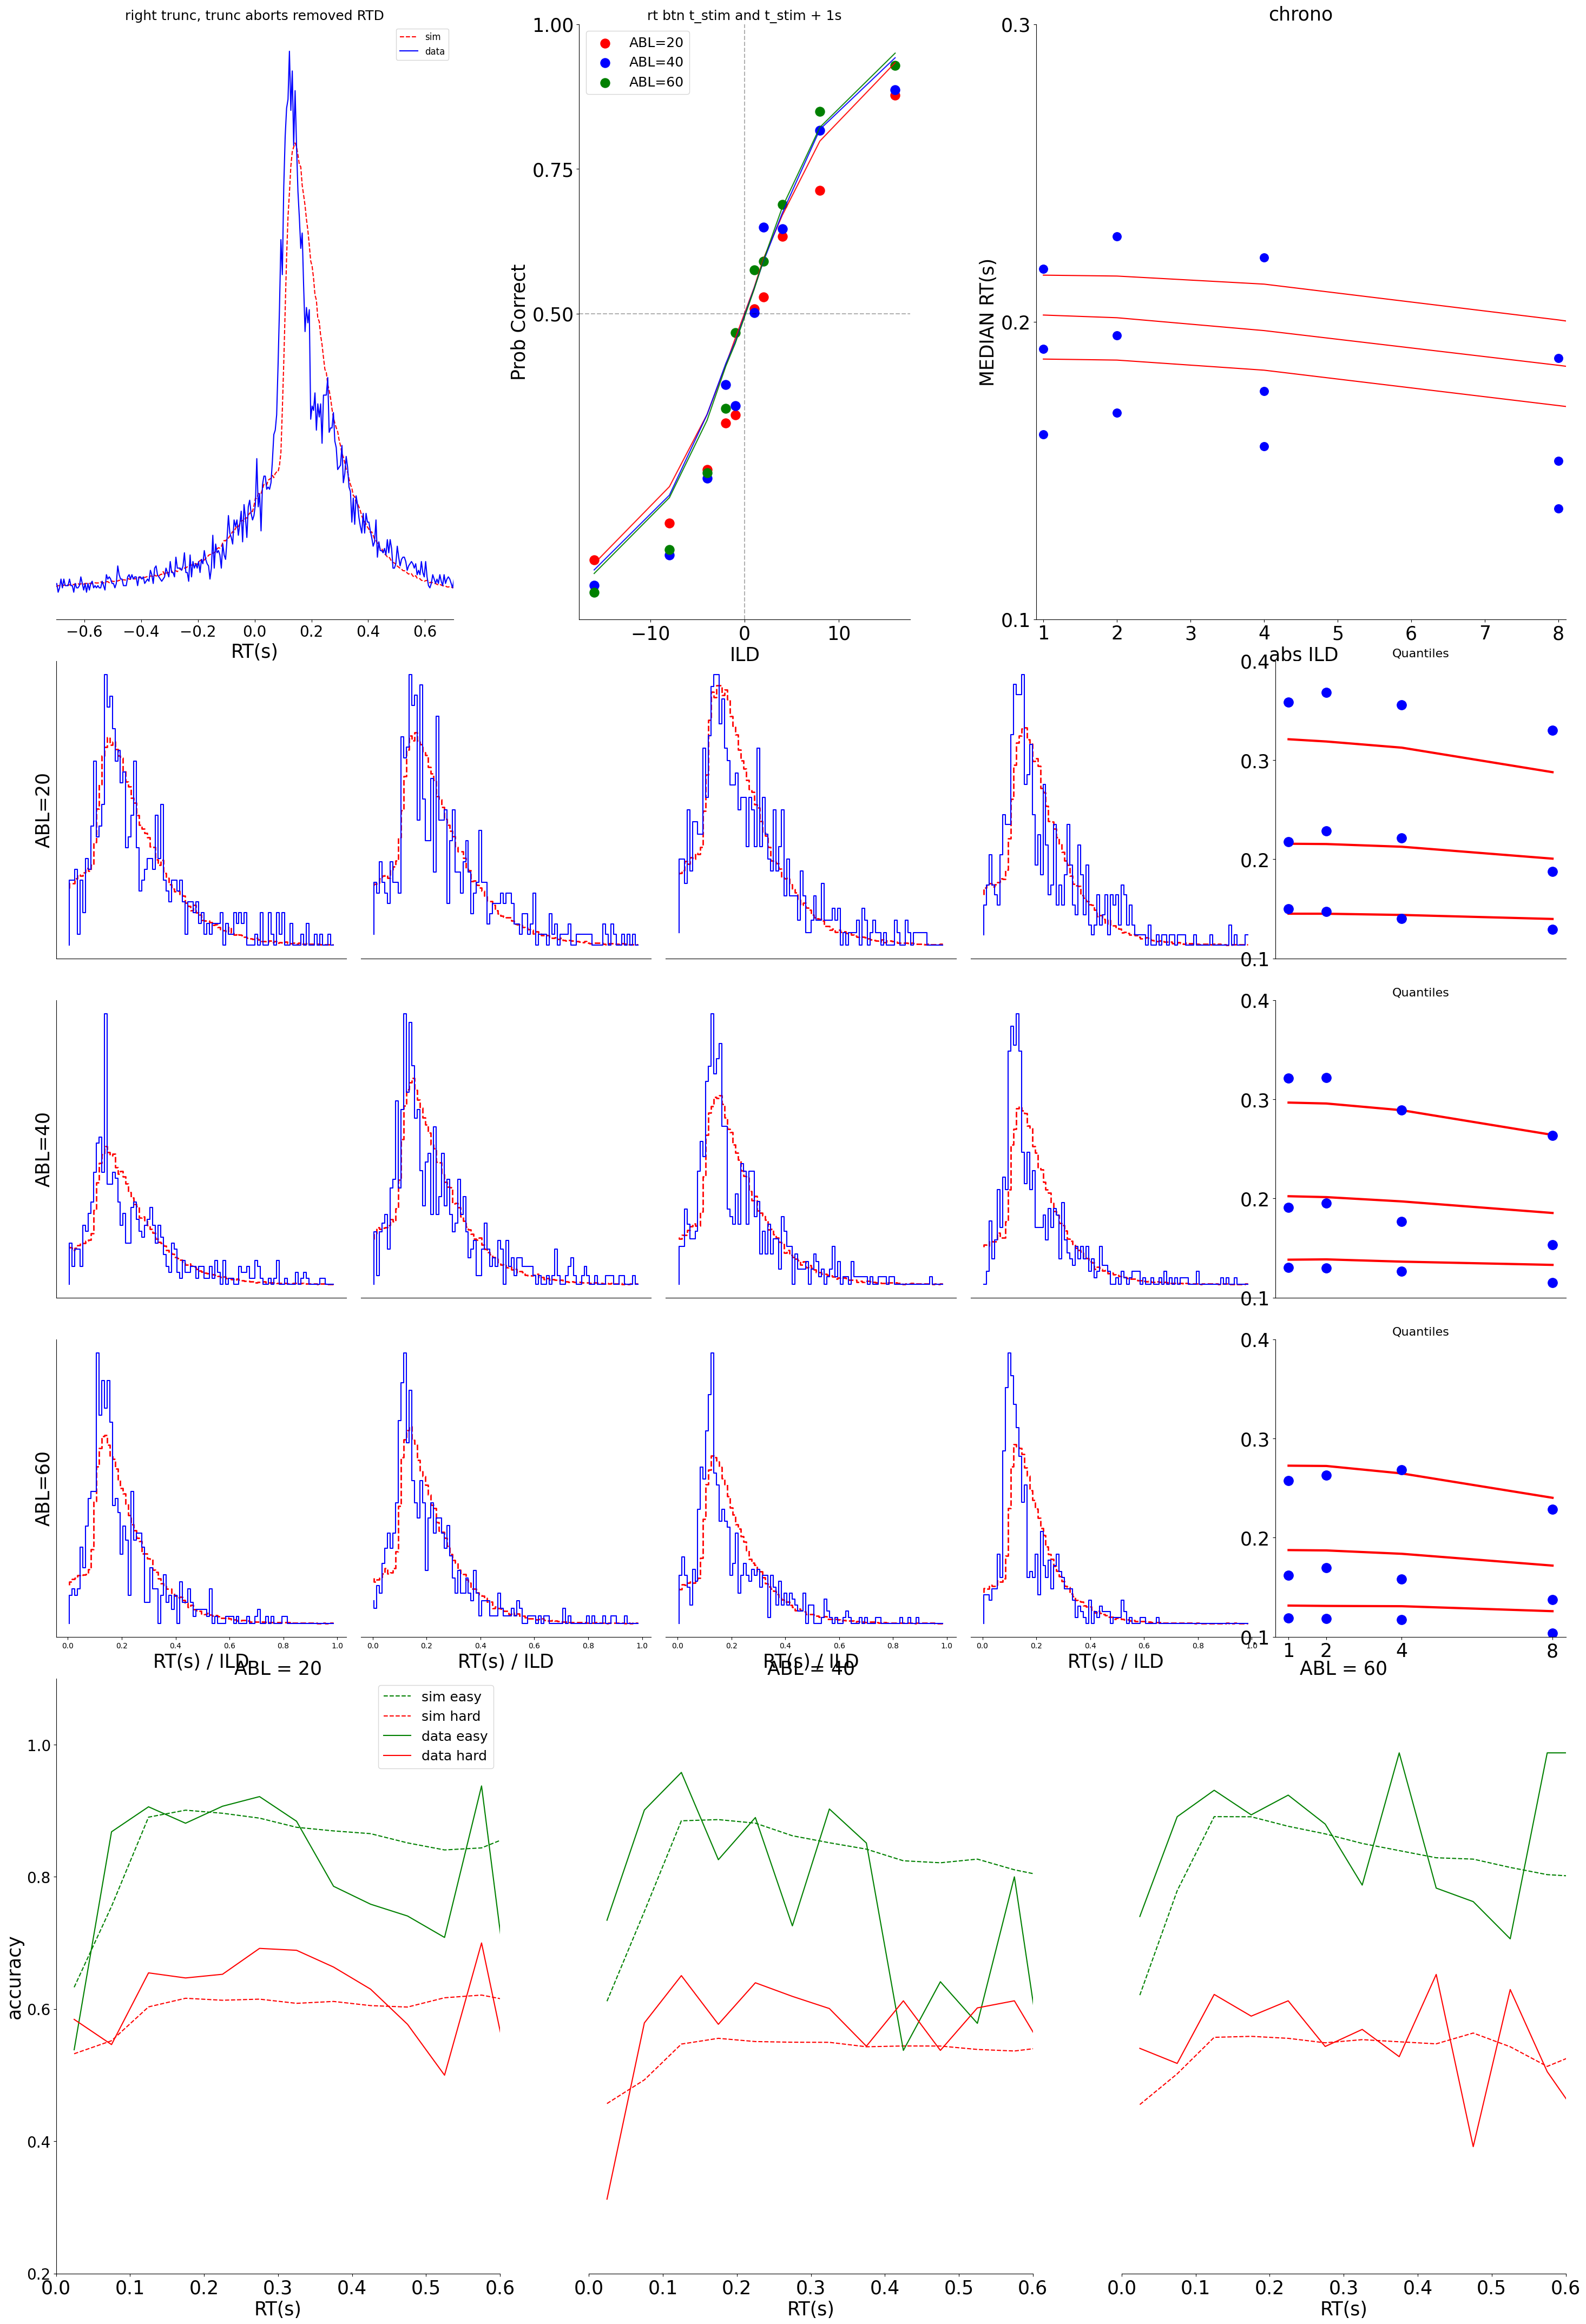

In [17]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-1, 1, 0.005)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)
### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
ax_psy.axvline(0, color='k', ls='--', alpha=0.3)
ax_psy.axhline(0.5, color='k', ls='--', alpha=0.3)

### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color='r')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color='b', marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.4, 0.1))
ax_chrono.set_ylim(0.1, 0.3)

### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(0, 1, 0.01)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            sim_pd = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            data_pd = data_df_led_on_valid[(data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=2)
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
        
            if a == len(ABL_arr) - 1:
                ax.set_xlabel('RT(s) / ILD', fontsize=25)
            if j == 0:
                ax.set_ylabel(f'ABL={ABL}', fontsize=25)
                ax.tick_params(axis='y', which='major', labelsize=20)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            if j != 0:
                ax.spines['left'].set_visible(False)

            ax.set_yticks([])
        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD[:-1], sim_qs[:-1,:], lw=3,color='r')
            ax.plot(all_pos_ILD[:-1], data_qs[:-1,:], linestyle='', marker='.', markersize=25, color='b')
            ax.set_title('Quantiles', fontsize=16)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
        
            # increase font size of x-axis labels
            ax.tick_params(axis='x', which='major', labelsize=25)
            ax.tick_params(axis='y', which='major', labelsize=25)
            ax.set_ylim(0.1, 0.4)
            ax.set_yticks(np.arange(0.1, 0.5, 0.1))
            ax.set_xticks(all_pos_ILD[:-1])
        # Format spines
        
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.05)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)


